# CS 180 Final Project: Classifying stress levels by applying $k$-nearest neighbors using different lifestyle factors

In [362]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [363]:
file_url = 'https://raw.githubusercontent.com/daryll-ko/stress/18a2bd7178aa1cfe48c027b1e2e03f9dbfeed161/Wellbeing_and_lifestyle_data_Kaggle.csv'
df = pd.read_csv(file_url)
print(df.head())

  Timestamp  FRUITS_VEGGIES DAILY_STRESS  PLACES_VISITED  CORE_CIRCLE  \
0    7/7/15               3            2               2            5   
1    7/7/15               2            3               4            3   
2    7/7/15               2            3               3            4   
3    7/7/15               3            3              10            3   
4    7/7/15               5            1               3            3   

   SUPPORTING_OTHERS  SOCIAL_NETWORK  ACHIEVEMENT  DONATION  BMI_RANGE  ...  \
0                  0               5            2         0          1  ...   
1                  8              10            5         2          2  ...   
2                  4              10            3         2          2  ...   
3                 10               7            2         5          2  ...   
4                 10               4            2         4          2  ...   

   SLEEP_HOURS  LOST_VACATION  DAILY_SHOUTING  SUFFICIENT_INCOME  \
0            7    

## Preprocessing

In [364]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15972 entries, 0 to 15971
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Timestamp                15972 non-null  object 
 1   FRUITS_VEGGIES           15972 non-null  int64  
 2   DAILY_STRESS             15972 non-null  object 
 3   PLACES_VISITED           15972 non-null  int64  
 4   CORE_CIRCLE              15972 non-null  int64  
 5   SUPPORTING_OTHERS        15972 non-null  int64  
 6   SOCIAL_NETWORK           15972 non-null  int64  
 7   ACHIEVEMENT              15972 non-null  int64  
 8   DONATION                 15972 non-null  int64  
 9   BMI_RANGE                15972 non-null  int64  
 10  TODO_COMPLETED           15972 non-null  int64  
 11  FLOW                     15972 non-null  int64  
 12  DAILY_STEPS              15972 non-null  int64  
 13  LIVE_VISION              15972 non-null  int64  
 14  SLEEP_HOURS           

Its great that we have no null values, let's just handle our categorical fields.

In [365]:
# Drop the 'Timestamp' field

df.drop(["Timestamp"], axis=1, inplace=True)
df.columns

Index(['FRUITS_VEGGIES', 'DAILY_STRESS', 'PLACES_VISITED', 'CORE_CIRCLE',
       'SUPPORTING_OTHERS', 'SOCIAL_NETWORK', 'ACHIEVEMENT', 'DONATION',
       'BMI_RANGE', 'TODO_COMPLETED', 'FLOW', 'DAILY_STEPS', 'LIVE_VISION',
       'SLEEP_HOURS', 'LOST_VACATION', 'DAILY_SHOUTING', 'SUFFICIENT_INCOME',
       'PERSONAL_AWARDS', 'TIME_FOR_PASSION', 'WEEKLY_MEDITATION', 'AGE',
       'GENDER', 'WORK_LIFE_BALANCE_SCORE'],
      dtype='object')

Now let's look at our 'DAILY_STRESS' field. Weird how its of type object when its values are suppose to be between integers 0-5. There must be a mismatched value!

In [366]:
mismatched_row = df[~df['DAILY_STRESS'].str.match(r'^[0-5]$', na=False)]
print(mismatched_row)

       FRUITS_VEGGIES DAILY_STRESS  PLACES_VISITED  CORE_CIRCLE  \
10005               3       1/1/00               1            2   

       SUPPORTING_OTHERS  SOCIAL_NETWORK  ACHIEVEMENT  DONATION  BMI_RANGE  \
10005                 10              10            5         5          2   

       TODO_COMPLETED  ...  SLEEP_HOURS  LOST_VACATION  DAILY_SHOUTING  \
10005               6  ...            6             10               1   

       SUFFICIENT_INCOME  PERSONAL_AWARDS  TIME_FOR_PASSION  \
10005                  2               10                 8   

       WEEKLY_MEDITATION       AGE  GENDER  WORK_LIFE_BALANCE_SCORE  
10005                  2  21 to 35    Male                    682.6  

[1 rows x 23 columns]


DAILY_STRESS of 1/1/00 how'd that get there 🤷‍♂️

In [367]:
# Convert 'DAILY_STRESS' field to numeric

df['DAILY_STRESS'] = pd.to_numeric(df['DAILY_STRESS'], errors='coerce')
print(df['DAILY_STRESS'].describe())

count    15971.000000
mean         2.791685
std          1.367801
min          0.000000
25%          2.000000
50%          3.000000
75%          4.000000
max          5.000000
Name: DAILY_STRESS, dtype: float64


In [368]:
# Fill in mismatched value in 'DAILY_STRESS' with the integer mean of the column

average_stress = round(df['DAILY_STRESS'].mean())
df['DAILY_STRESS'].fillna(average_stress, inplace=True)

In [369]:
# Encode the 'GENDER' and 'AGE' fields

label_encoder = LabelEncoder()
df['GENDER'] = label_encoder.fit_transform(df['GENDER'])    # 0: Female, 1: Male
df['AGE'] = label_encoder.fit_transform(df['AGE'])          # 1: 36-50, 2: > 50, 0: 21-35 3: < 20

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15972 entries, 0 to 15971
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   FRUITS_VEGGIES           15972 non-null  int64  
 1   DAILY_STRESS             15972 non-null  float64
 2   PLACES_VISITED           15972 non-null  int64  
 3   CORE_CIRCLE              15972 non-null  int64  
 4   SUPPORTING_OTHERS        15972 non-null  int64  
 5   SOCIAL_NETWORK           15972 non-null  int64  
 6   ACHIEVEMENT              15972 non-null  int64  
 7   DONATION                 15972 non-null  int64  
 8   BMI_RANGE                15972 non-null  int64  
 9   TODO_COMPLETED           15972 non-null  int64  
 10  FLOW                     15972 non-null  int64  
 11  DAILY_STEPS              15972 non-null  int64  
 12  LIVE_VISION              15972 non-null  int64  
 13  SLEEP_HOURS              15972 non-null  int64  
 14  LOST_VACATION         

In [370]:
X = df.drop(['DAILY_STRESS'], axis = 1)
y = df['DAILY_STRESS']

To give us our best chance let's take into account feature importance and get rid of features that aren't helpful.

Unfortunately, feature importance is not defined for the KNN Classification algorithm. Although not specifically fit for this algorithm, we can try use the feature_importances_ attribute of a random forest classifier. This gives us the most important features for the entire model, just not specifically on the sample we are predicting.

In [371]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
model.fit(X, y)

importances = model.feature_importances_
feature_importances = pd.DataFrame({"feature": X.columns, "importance": importances})
feature_importances = feature_importances.sort_values("importance", ascending=False)

print(feature_importances)

                    feature  importance
21  WORK_LIFE_BALANCE_SCORE    0.101690
10              DAILY_STEPS    0.054411
14           DAILY_SHOUTING    0.053540
8            TODO_COMPLETED    0.053486
2               CORE_CIRCLE    0.052099
5               ACHIEVEMENT    0.051815
16          PERSONAL_AWARDS    0.051529
1            PLACES_VISITED    0.051305
3         SUPPORTING_OTHERS    0.050665
9                      FLOW    0.050022
17         TIME_FOR_PASSION    0.049620
11              LIVE_VISION    0.048808
4            SOCIAL_NETWORK    0.047951
18        WEEKLY_MEDITATION    0.047846
0            FRUITS_VEGGIES    0.041966
6                  DONATION    0.040751
12              SLEEP_HOURS    0.039372
13            LOST_VACATION    0.036463
19                      AGE    0.033097
7                 BMI_RANGE    0.016190
20                   GENDER    0.014751
15        SUFFICIENT_INCOME    0.012624


Let's make use of the half most important features!

In [372]:
num_top_features = len(feature_importances) // 2
top_features = feature_importances.nlargest(num_top_features, 'importance')

print(top_features)

# Create a new DataFrame with only the top features
X_top_features = X[top_features['feature']]

                    feature  importance
21  WORK_LIFE_BALANCE_SCORE    0.101690
10              DAILY_STEPS    0.054411
14           DAILY_SHOUTING    0.053540
8            TODO_COMPLETED    0.053486
2               CORE_CIRCLE    0.052099
5               ACHIEVEMENT    0.051815
16          PERSONAL_AWARDS    0.051529
1            PLACES_VISITED    0.051305
3         SUPPORTING_OTHERS    0.050665
9                      FLOW    0.050022
17         TIME_FOR_PASSION    0.049620


In [373]:
# Scaling the features
scaler = MinMaxScaler(feature_range=(-1, 1))
X_scaled = scaler.fit_transform(X)

print(X_scaled)

[[ 0.2        -0.6         0.         ... -0.33333333 -1.
  -0.23868313]
 [-0.2        -0.2        -0.4        ... -0.33333333 -1.
   0.03233392]
 [-0.2        -0.4        -0.2        ... -0.33333333 -1.
  -0.10875955]
 ...
 [ 0.6        -1.          1.         ... -1.          1.
   0.3909465 ]
 [-0.6         1.          0.6        ... -1.         -1.
   0.18753674]
 [ 1.         -1.         -0.6        ... -1.         -1.
   0.00764256]]


In [374]:
X_train, x_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.3, random_state = 99)

print(X_train.shape)
print(x_test.shape)

(11180, 22)
(4792, 22)


In [375]:
# Let's try with 5 neighbors
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

KNeighborsClassifier()

Text(113.9222222222222, 0.5, 'True Value')

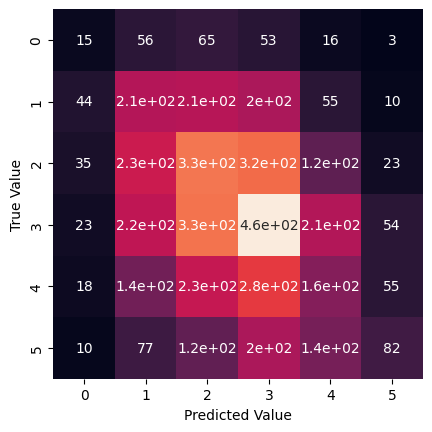

In [376]:
y_pred = knn.predict(x_test)
mat1 = confusion_matrix(y_test, y_pred)
sns.heatmap(mat1, square = True, annot = True, cbar = False)
plt.xlabel('Predicted Value')
plt.ylabel('True Value')
# print(confusion_matrix(y_test, y_pred))

The confusion matrix looks kinda weird...

In [377]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.10      0.07      0.08       208
         1.0       0.22      0.29      0.25       725
         2.0       0.26      0.31      0.28      1061
         3.0       0.31      0.36      0.33      1297
         4.0       0.23      0.18      0.20       870
         5.0       0.36      0.13      0.19       631

    accuracy                           0.26      4792
   macro avg       0.25      0.22      0.22      4792
weighted avg       0.27      0.26      0.26      4792



Wow a 0.26 accuracy! maybe we can try different values of k to see if we can do better.

In [378]:
error_rate = []

for i in range(1,40):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(x_test)
    error_rate.append(np.mean(pred_i != y_test))

Text(0, 0.5, 'Error Rate')

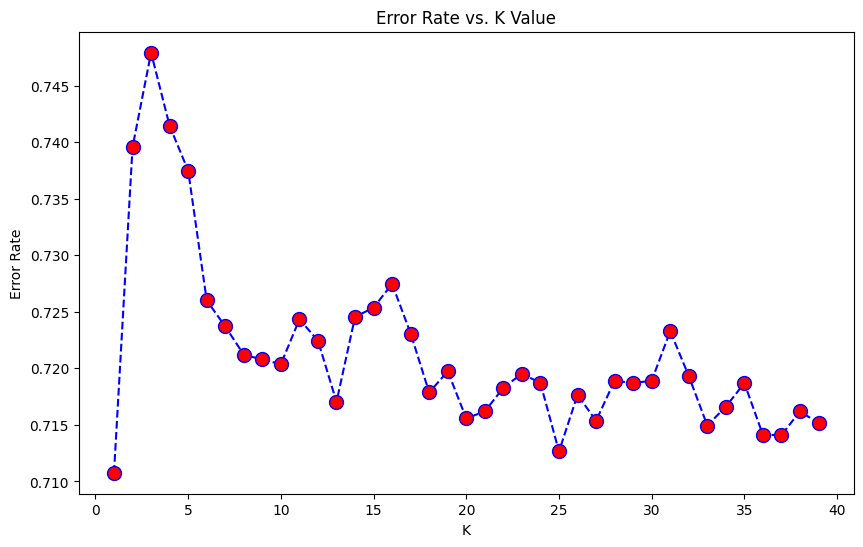

In [379]:
plt.figure(figsize=(10,6))
plt.plot(range(1,40),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

On the bright side we can pretty accurately predict what isn't their stress level?

Let's try a different model! How about neural networks.

In [380]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(5),max_iter=10000,learning_rate_init=0.001,activation='tanh')
mlp.fit(X_train, y_train)

predictions = mlp.predict(x_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       208
         1.0       1.00      1.00      1.00       725
         2.0       1.00      1.00      1.00      1061
         3.0       1.00      1.00      1.00      1297
         4.0       1.00      1.00      1.00       870
         5.0       1.00      1.00      1.00       631

    accuracy                           1.00      4792
   macro avg       1.00      1.00      1.00      4792
weighted avg       1.00      1.00      1.00      4792



Wow what a difference! perfect accuracy!

Text(113.9222222222222, 0.5, 'True Value')

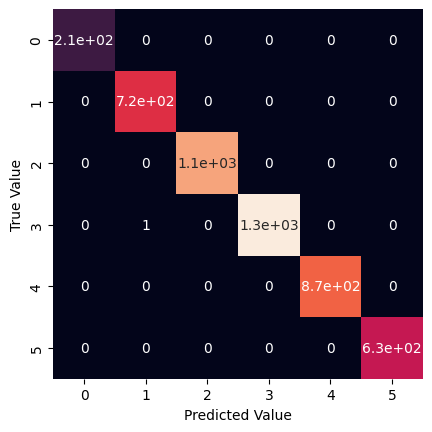

In [381]:
mat = confusion_matrix(y_test, predictions)
sns.heatmap(mat, square = True, annot = True, cbar = False)
plt.xlabel('Predicted Value')
plt.ylabel('True Value')